# Analysis of Repair Rates in TCR Regions

The DNA molecule is a chemical representation of every organism's identity. Therefore, it is vital for a cell to employ mechanisms to potect and repair this essential structure once it has been damaged. Several mutatoxic agents can create lesions and jeopadise the molecular intergrity. UV light is a famous representative that can induce CPDs. The nucleotide excision repair (NER) pathway has been identified as a evolutionary preserved mechanism that can remove this type of damage. However, the exact dynamics in living cells remain in the dark. 

NER is classicly divided into two recognition pathways; the first one is transcription-coupled (TCR), the other is genome-wide (GGR). We therefore expect different dynamics in these two respective regions. In the following I want ot investigate by how much they differ within the first 20 minutes. The aim is to increase understanding of potentially necessary aspects that are needed to be incorporated into a modelling approach. In particular, I want to investigate what repair rate range we should expect and whether there might be subclasses with in each recognition pathway. Unsurprisingly, there seems to be no bias with respect to the chromosome. As approximately 90\% of non-transcribed regions do not exhibit more than 20\% repair, we set the threshold for a region where the effect of TCR can be observed to 20 minutes. We compare to sets of coordinates for the definition of non-transcribed region. The first one comes from Park, et al. Nucleic acids research 42.6 (2014). The other is the official GFF annotation file from NCBI.

## Load the Data and Define Functions

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import gtfparse

from datahandler import reader

In [2]:
def load_transcript():
    curr_dir = os.getcwd()
    tss = pd.read_csv(
        '%s/data/ref/GSE49026_S-TSS.txt' % curr_dir,
        delimiter='\t',
        usecols=['chr', 'coordinate', 'ORF']
    )
    tss.columns = ['chr', 'start', 'ORF']
    pas = pd.read_csv(
        '%s/data/ref/GSE49026_S-PAS.txt' % curr_dir,
        delimiter='\t',
        usecols=['coordinate', 'ORF']
    )
    pas.columns = ['end', 'ORF']
    return pd.merge(left=tss, right=pas, left_on='ORF', right_on='ORF')

In [3]:
def load(time_step):
    curr_dir = os.getcwd()
    if time_step == '0-20m':
        start_minus_path = '%s/data/seq/0h_A2_minus.bw' % curr_dir
        start_plus_path = '%s/data/seq/0h_A2_plus.bw' % curr_dir
        end_minus_path = '%s/data/seq/20m_A2_minus.bw' % curr_dir
        end_plus_path = '%s/data/seq/20m_A2_plus.bw' % curr_dir
    elif time_step == '0-1h':
        start_minus_path = '%s/data/seq/0h_A1_minus.bw' % curr_dir
        start_plus_path = '%s/data/seq/0h_A1_plus.bw' % curr_dir
        end_minus_path = '%s/data/seq/1h_A1_minus.bw' % curr_dir
        end_plus_path = '%s/data/seq/1h_A1_minus.bw' % curr_dir
    elif time_step == '0-2h':
        start_minus_path = '%s/data/seq/0h_A2_minus.bw' % curr_dir
        start_plus_path = '%s/data/seq/0h_A2_plus.bw' % curr_dir
        end_minus_path = '%s/data/seq/2h_A2_minus.bw' % curr_dir
        end_plus_path = '%s/data/seq/2h_A2_plus.bw' % curr_dir
    elif time_step == '20m-2h':
        start_minus_path = '%s/data/seq/20m_A2_minus.bw' % curr_dir
        start_plus_path = '%s/data/seq/20m_A2_plus.bw' % curr_dir
        end_minus_path = '%s/data/seq/2h_A2_minus.bw' % curr_dir
        end_plus_path = '%s/data/seq/2h_A2_plus.bw' % curr_dir
    else:
        raise ValueError('Invalid data identifier.')

    bw_files = [start_minus_path, start_plus_path, end_minus_path, end_plus_path]
    bw_objs = []
    for bw in bw_files:
        bw_objs.append(reader.load_big_file(bw, rel_path='', is_abs_path=True))

    tss_pas = load_transcript()
    ref_genome = reader.load_fast('%s/data/ref/SacCer3.fa' % curr_dir, is_abs_path=True, is_fastq=False)
    return bw_objs, tss_pas, ref_genome

In [4]:
def num_pydim_pos(chrom, bins, direct, dna_seq):
    combinations = ['TT', 'CT', 'TC', 'CC']
    chrom_seq = list(filter(lambda x: x.id == chrom, dna_seq))[0]
    seq = chrom_seq.seq if direct == '+' else chrom_seq.reverse_complement().seq
    num_pydim = []
    num_overlap = []
    for i in range(len(bins) - 1):
        ind = set()
        for c in combinations:
            c_ind = set([m.start() for m in re.finditer(c, str(seq[bins[i]:bins[i+1]]))])
            ind = ind.union(c_ind)
        num_pydim.append(len(list(ind)))
    
    return np.flip(num_pydim)

In [5]:
def analysis(chrom, data, transcripts, seq, is_ig=False, normalisation=None):
    chrom_trans = transcripts[transcripts['chr'] == chrom]
    num_bins = 3 if not is_ig else 1
    cs = data[0].chroms(chrom)
    cd_start_m = np.nan_to_num(data[0].values(chrom, 0, cs), nan=.0)
    cd_start_p = np.nan_to_num(data[1].values(chrom, 0, cs), nan=.0)
    cd_end_m = np.nan_to_num(data[2].values(chrom, 0, cs), nan=0.)
    cd_end_p = np.nan_to_num(data[3].values(chrom, 0, cs), nan=0.)
    
    if not is_ig:
        df_chrom = pd.DataFrame(columns=['rr', 'pos', 'chr', 'ORF', 'start', 'end'])
    else:
        df_chrom = pd.DataFrame(columns=['rr', 'chr', 'start', 'end', 'sense'])
    for t in chrom_trans.iterrows():
        t = t[1]
        start = t['start']
        end = t['end']
        read = '-'  if not is_ig else t['strand']  # Opposite of the strand where the transcript is defined
        if not is_ig:
            if start > end:
                read = '+'
                end_temp = start
                start = end
                end = end_temp
            
        if not is_ig:
            # Add - 1 because zero based arrays
            if read == '+':
                bins = np.linspace(start - 1, end, num_bins + 1).astype('int')
                c_start = np.flip(np.add.reduceat(cd_start_p, bins)[:-1])
                c_end = np.flip(np.add.reduceat(cd_end_p, bins)[:-1])
            else:
                bins = np.linspace(start - 1, end, num_bins + 1).astype('int')
                c_start = np.add.reduceat(cd_start_m, bins)[:-1]
                c_end = np.add.reduceat(cd_end_m, bins)[:-1]
                bins = np.linspace(cs - end, cs - start, num_bins + 1).astype('int')
        else:
            if read == '+':
                bins = np.linspace(start, end-1, num_bins + 1).astype('int')
                c_start = np.add.reduceat(cd_start_p, bins)[:-1]
                c_end = np.add.reduceat(cd_end_p, bins)[:-1]
            else:
                bins = np.linspace(start, end-1, num_bins + 1).astype('int')
                c_start = np.flip(np.add.reduceat(cd_start_m, bins)[:-1])
                c_end = np.flip(np.add.reduceat(cd_end_m, bins)[:-1])
                bins = np.linspace(cs - end, cs - start, num_bins + 1).astype('int')
            
        num_pydim = num_pydim_pos(chrom=chrom, bins=bins, direct=read, dna_seq=seq)
        if is_ig:
            num_pydim = np.flip(num_pydim)
            
        c_start = np.nan_to_num(c_start / (2 * num_pydim), nan=.0, neginf=.0, posinf=.0)
        c_end = np.nan_to_num(c_end / (2 * num_pydim), nan=.0, neginf=.0, posinf=.0)
        rr = np.nan_to_num((c_start - c_end) / c_start, nan=.0, neginf=.0, posinf=.0)
        if normalisation is not None and normalisation != 0.:
            rr /= normalisation
        df_temp = pd.DataFrame(rr, columns=['rr'])
        if not is_ig:
            df_temp['pos'] = ['start', 'centre', 'end'] 
            df_temp['ORF'] = [t['ORF']] * num_bins
        else:
            df_temp['chr'] = [c]
            df_temp['sense'] = read 
            
        df_temp['chr'] = [c] * num_bins
        df_temp['start'] = [t['start']] * num_bins
        df_temp['end'] = [t['end']] * num_bins
        df_chrom = df_chrom.append(df_temp)
            
    return df_chrom  

## Transcripts

The graphs present the repair rate distribution per chromosome and per position in the gene (*start*, *centre*, *end*). As it can be seen in the plots below, transcripts possess a large variance of repair rates. However, they do not differ between chromsomes. It might be therefore possible to treat every chromosome as independent. There is a slight decrease in the repair rates towards the end of the transcripts. However, as the respective spread is large, it might be sufficient to treat all positions in a single transcript equally likely to be repaired. Moreover, many of the violin plots possess chunky regions which indicate subgroups with different dynamics. Visual inspection allowed 0.2 to be defined as a threshold to distinguish between quick and slow repair in transcribed regions. Moreover, as it can be observed in later sections, 90\% of the intergenic region exhibit less than 20\% repair. It seems to be therefore a reasonable threshold to investigate the different dynamics between GGR and TCR. Areas with zero or negative repair rates are interpreted as exhibiting no or negligible repair.

In [6]:
bw, tss_pas, seq = load('0-20m')
df_repair = pd.DataFrame(columns=['rr', 'pos', 'chr', 'ORF', 'start', 'end'])

In [7]:
for c in bw[0].chroms().keys():
    df_chrom = analysis(c, data=bw, transcripts=tss_pas, seq=seq)
    df_repair = df_repair.append(df_chrom)

In [8]:
detect_repair = df_repair[df_repair['rr'] > 0]
print('Positions with active repair: %s' % len(detect_repair))

Positions with active repair: 11586


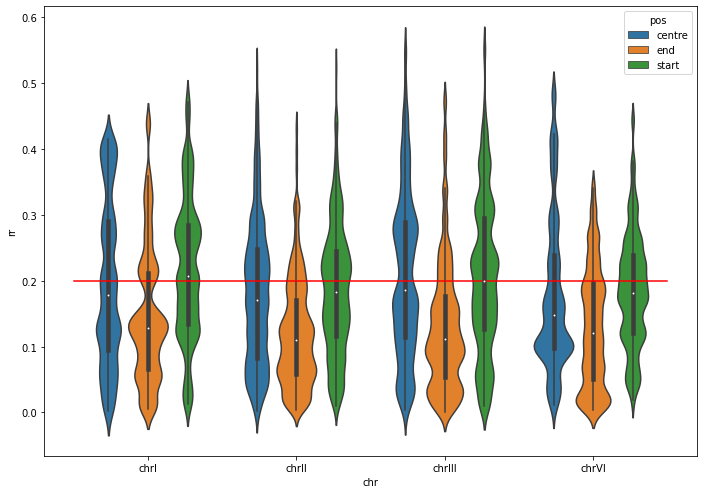

In [9]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='pos', bw=.15, data=detect_repair[detect_repair.chr.isin(['chrI', 'chrII', 'chrIII', 'chrVI'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

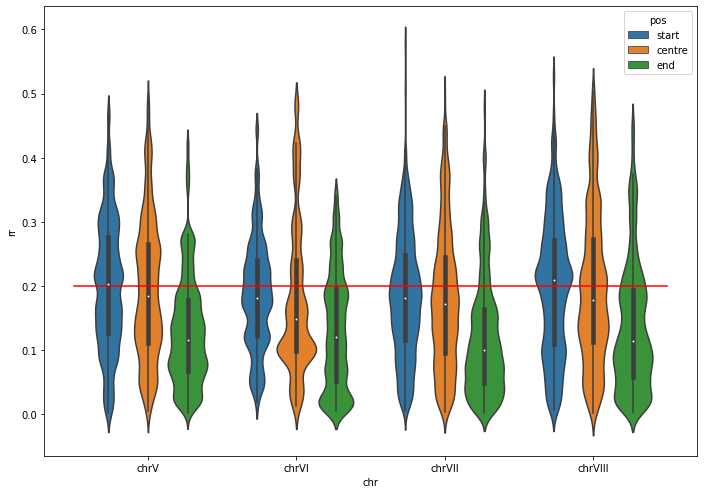

In [10]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='pos', bw=.15, data=detect_repair[detect_repair.chr.isin(['chrV', 'chrVI', 'chrVII', 'chrVIII'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

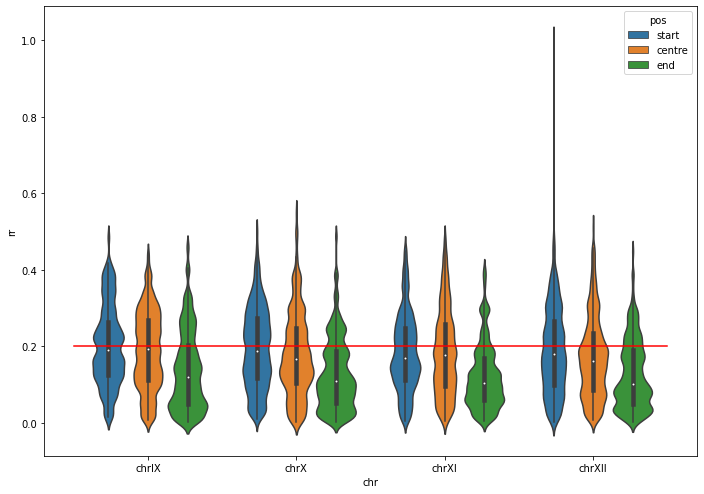

In [11]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='pos', bw=.15, data=detect_repair[detect_repair.chr.isin(['chrIX', 'chrX', 'chrXI', 'chrXII'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

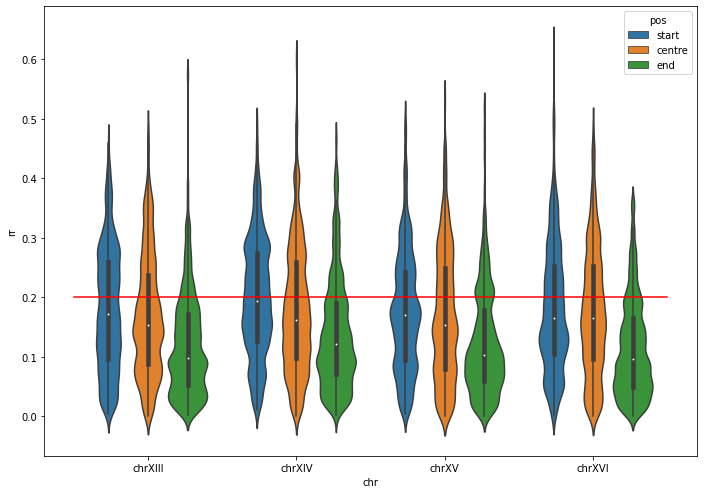

In [12]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='pos', bw=.15, data=detect_repair[detect_repair.chr.isin(['chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chrXVII'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

In [13]:
group_low = df_repair[np.logical_and(df_repair['rr'] <= 0, df_repair['pos']=='start')][['rr', 'chr', 'ORF', 'start', 'end']]
group_medium = df_repair[np.logical_and(np.logical_and(0 < df_repair['rr'], df_repair['rr'] < .2),  df_repair['pos']=='start')][['rr', 'chr', 'ORF', 'start', 'end']]
group_high = df_repair[np.logical_and(df_repair['rr'] >= .2,  df_repair['pos']=='start')][['rr', 'chr', 'ORF', 'start', 'end']]

In [14]:
len(group_low) + len(group_medium) + len(group_high) == len(tss_pas)

True

In [15]:
curr_dir = os.getcwd()
group_low.to_csv('%s/data/ref/trans_low.txt' % curr_dir)
group_medium.to_csv('%s/data/ref/trans_medium.txt' % curr_dir)
group_high.to_csv('%s/data/ref/trans_high.txt' % curr_dir)

## Intergenic regions
We expect intergenic regions to be only repaired by GGR. It is commonly assumed that the genome-wide repair kinetics are slower. The plots below show the repair rates per strand and chromosome. As expected, there is neither a difference in repair between chromosomes, nor between strands. Interestingly, repair dynamics remain predominantly below the 0.2 threshold defined in the paragraph above. Repair rates are thus much less spread out. Only few areas possess repair rates larger than 0.2. A comparison with lab-internal SLAM-seq data (not shown) could potentially indicate that that these outliers are nevertheless repaired through TCR. This is due to the fact that we can observe transcription nonetheless. However, this conclusion is too premature to be considered important. It is therefore deemed to be sufficient to model all of GGR with the same kinetical regime.

In [16]:
def intergenic_regions(transcripts, chrom_sizes):
    df_ig = pd.DataFrame(columns=['chr', 'start', 'end', 'strand'])
    for chrom in transcripts['chr'].unique():
        intergenic_mask_m = np.ones(chrom_sizes[chrom])
        intergenic_mask_p = np.ones(chrom_sizes[chrom])
        for t in transcripts[transcripts['chr'] == chrom].iterrows():
            t = t[1]
            start = t['start']
            end = t['end']
            try:
                strand = t['strand']
                if strand == '-':
                    intergenic_mask_m[start:end] = 0
                else:
                    intergenic_mask_p[start:end] = 0
            except:
                strand = '-' if start > end else '+'
                if strand == '-':
                    intergenic_mask_m[end:start] = 0
                else:
                    intergenic_mask_p[start:end] = 0
        
        borders_m = np.where(intergenic_mask_m != np.roll(intergenic_mask_m, shift=-1))[0]
        if intergenic_mask_m[0] == 0:
            igr_start_m = borders_m[::2]
            igr_end_m = borders_m[1::2]
        else:
            igr_start_m = borders_m[1::2]
            igr_end_m = borders_m[0::2]
            igr_start_m = np.insert(igr_start_m, 0, 0)
            igr_end_m = np.append(igr_end_m, intergenic_mask_m.size)
        df_temp = pd.DataFrame(igr_start_m, columns=['start'])
        df_temp['end'] = igr_end_m
        df_temp['chr'] = [chrom] * igr_start_m.size
        df_temp['strand'] = ['-'] * igr_start_m.size
        df_ig = df_ig.append(df_temp)
        
        borders_p = np.where(intergenic_mask_p != np.roll(intergenic_mask_p, shift=-1))[0]
        if intergenic_mask_p[0] == 0:
            igr_start_p = borders_p[::2]
            igr_end_p = borders_p[1::2]
        else:
            igr_start_p = borders_p[1::2]
            igr_end_p = borders_p[0::2]
            igr_start_p = np.insert(igr_start_p, 0, 0)
            igr_end_p = np.append(igr_end_p, intergenic_mask_p.size)
        df_temp = pd.DataFrame(igr_start_p, columns=['start'])
        df_temp['end'] = igr_end_p
        df_temp['chr'] = [chrom] * igr_start_p.size
        df_temp['strand'] = ['+'] * igr_start_p.size
        df_ig = df_ig.append(df_temp)

    return df_ig

In [17]:
df_ig = intergenic_regions(tss_pas, bw[0].chroms())

In [18]:
df_repair_ig = pd.DataFrame(columns=['rr', 'chr', 'start', 'end', 'sense'])
for c in bw[0].chroms().keys():
    df_chrom = analysis(c, data=bw, transcripts=df_ig, seq=seq, is_ig=True)
    df_repair_ig = df_repair_ig.append(df_chrom)

/tmp/ipykernel_10487/727070942.py:52: RuntimeWarning: invalid value encountered in true_divide
  c_start = np.nan_to_num(c_start / (2 * num_pydim), nan=.0, neginf=.0, posinf=.0)
/tmp/ipykernel_10487/727070942.py:53: RuntimeWarning: invalid value encountered in true_divide
  c_end = np.nan_to_num(c_end / (2 * num_pydim), nan=.0, neginf=.0, posinf=.0)
/tmp/ipykernel_10487/727070942.py:54: RuntimeWarning: invalid value encountered in true_divide
  rr = np.nan_to_num((c_start - c_end) / c_start, nan=.0, neginf=.0, posinf=.0)
/tmp/ipykernel_10487/727070942.py:54: RuntimeWarning: divide by zero encountered in true_divide
  rr = np.nan_to_num((c_start - c_end) / c_start, nan=.0, neginf=.0, posinf=.0)
/tmp/ipykernel_10487/727070942.py:52: RuntimeWarning: divide by zero encountered in true_divide
  c_start = np.nan_to_num(c_start / (2 * num_pydim), nan=.0, neginf=.0, posinf=.0)
/tmp/ipykernel_10487/727070942.py:53: RuntimeWarning: divide by zero encountered in true_divide
  c_end = np.nan_to_nu

In [19]:
detect_repair_ig = df_repair_ig[df_repair_ig['rr'] > 0]
print('Positions with active repair: %s' % len(detect_repair_ig))

Positions with active repair: 3133


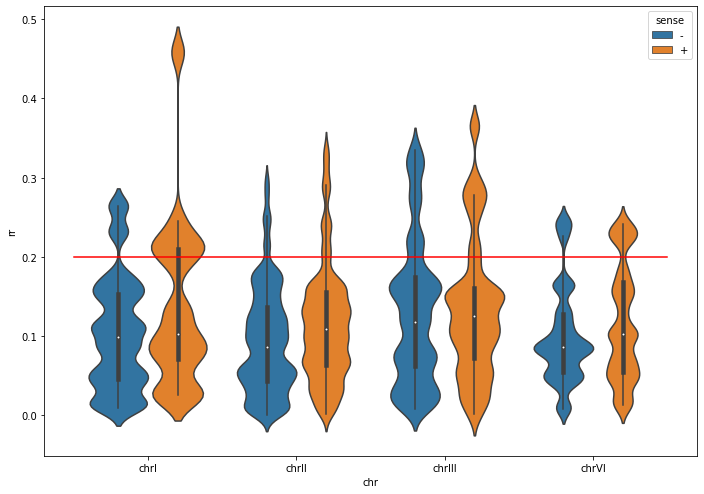

In [20]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='sense', bw=.15, data=detect_repair_ig[detect_repair_ig.chr.isin(['chrI', 'chrII', 'chrIII', 'chrVI'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

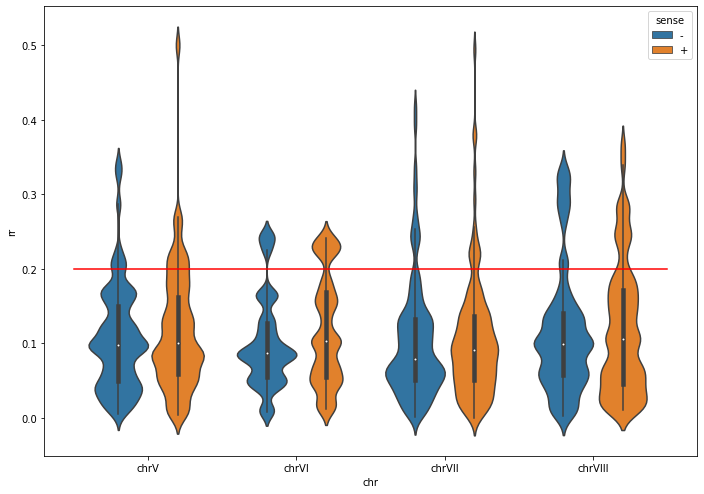

In [21]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='sense', bw=.15, data=detect_repair_ig[detect_repair_ig.chr.isin(['chrV', 'chrVI', 'chrVII', 'chrVIII'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

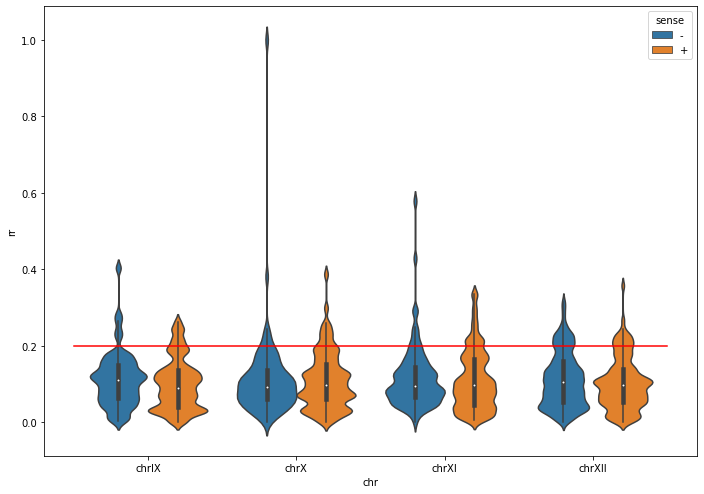

In [22]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='sense', bw=.15, data=detect_repair_ig[detect_repair_ig.chr.isin(['chrIX', 'chrX', 'chrXI', 'chrXII'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

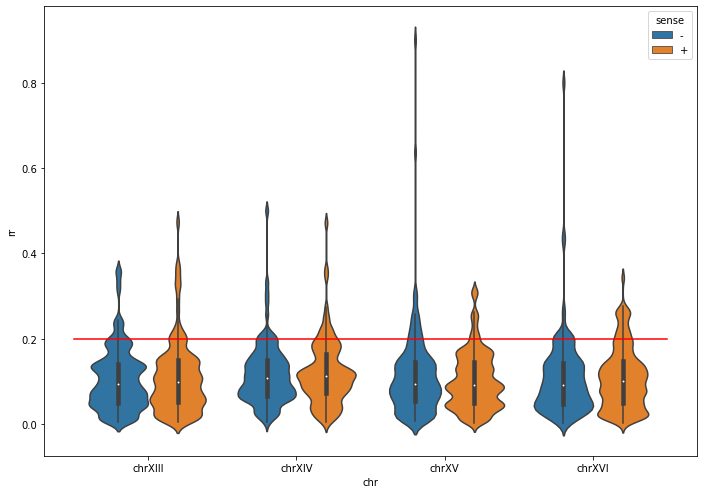

In [22]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='sense', bw=.15, data=detect_repair_ig[detect_repair_ig.chr.isin(['chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chrXVII'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

## Total Repair Distribution

As there are no chromosomal or strand specific biases, I show in the following an overview over the repair rate distribution of different areas.

In [52]:
rr_total = detect_repair_ig[['rr']]
rr_total = rr_total.append(detect_repair[['rr']])
types = ['Intergenic'] * len(detect_repair_ig['rr'])
types.extend(detect_repair['pos'])
rr_total['Region type'] = types

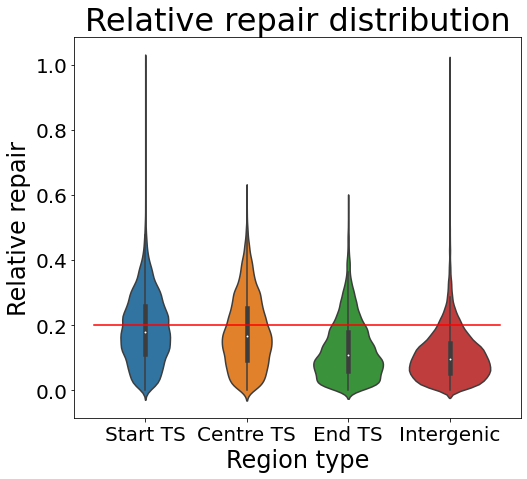

In [68]:
plt.figure(figsize=(8, 7))
sb.violinplot(x='Region type', y='rr', bw=.15, data=rr_total, order=['start', 'centre', 'end', 'Intergenic'])
plt.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.ylabel('Relative repair', fontsize=24)
plt.xlabel('Region type', fontsize=24)
plt.xticks(np.arange(4), ['Start TS', 'Centre TS', 'End TS', 'Intergenic'], fontsize=20)
plt.yticks(fontsize=20)
plt.title('Relative repair distribution', fontsize=32)
plt.savefig('figures/examples/rr_repair_distbrubtion.png')

In [65]:
np.sum(detect_repair_ig['rr'] < .2) / float(len(detect_repair_ig['rr']))

0.8895627194382381

## Comparison with the GTF Transcript Definition

In order to assess the reliability of the results we repeated the analysis using the transcript definition provided by the NCBI. There is indeed no significant difference detecable. 

In [23]:
df_ig.to_csv('%s/data/ref/ig_regions.txt' % curr_dir)

In [24]:
gtf_path = '%s/data/ref/sacCer3.ncbiRefSeq.gtf' % curr_dir
gtf = gtfparse.read_gtf(gtf_path)
intervals = gtf[gtf['feature'] == 'transcript'][['seqname', 'start', 'end', 'gene_name', 'strand']]
intervals.columns = ['chr', 'start', 'end', 'ORF', 'strand']

/home/leo/.local/lib/python3.8/site-packages/gtfparse/read_gtf.py:151: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(
/home/leo/.local/lib/python3.8/site-packages/gtfparse/read_gtf.py:151: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name', 'exon_number', 'exon_id']


In [25]:
df_ig_gtf = intergenic_regions(intervals, bw[0].chroms())

In [26]:
df_repair_ig_gtf = pd.DataFrame(columns=['rr', 'chr', 'start', 'end', 'sense'])
for c in bw[0].chroms().keys():
    df_chrom = analysis(c, data=bw, transcripts=df_ig_gtf, seq=seq, is_ig=True)
    df_repair_ig_gtf = df_repair_ig_gtf.append(df_chrom)

/tmp/ipykernel_8324/727070942.py:52: RuntimeWarning: invalid value encountered in true_divide
  c_start = np.nan_to_num(c_start / (2 * num_pydim), nan=.0, neginf=.0, posinf=.0)
/tmp/ipykernel_8324/727070942.py:53: RuntimeWarning: invalid value encountered in true_divide
  c_end = np.nan_to_num(c_end / (2 * num_pydim), nan=.0, neginf=.0, posinf=.0)
/tmp/ipykernel_8324/727070942.py:54: RuntimeWarning: invalid value encountered in true_divide
  rr = np.nan_to_num((c_start - c_end) / c_start, nan=.0, neginf=.0, posinf=.0)
/tmp/ipykernel_8324/727070942.py:52: RuntimeWarning: divide by zero encountered in true_divide
  c_start = np.nan_to_num(c_start / (2 * num_pydim), nan=.0, neginf=.0, posinf=.0)
/tmp/ipykernel_8324/727070942.py:53: RuntimeWarning: divide by zero encountered in true_divide
  c_end = np.nan_to_num(c_end / (2 * num_pydim), nan=.0, neginf=.0, posinf=.0)


In [27]:
detect_repair_ig_gtf = df_repair_ig_gtf[df_repair_ig_gtf['rr'] > 0]
print('Positions with active repair: %s' % len(detect_repair_ig_gtf))

Positions with active repair: 3428


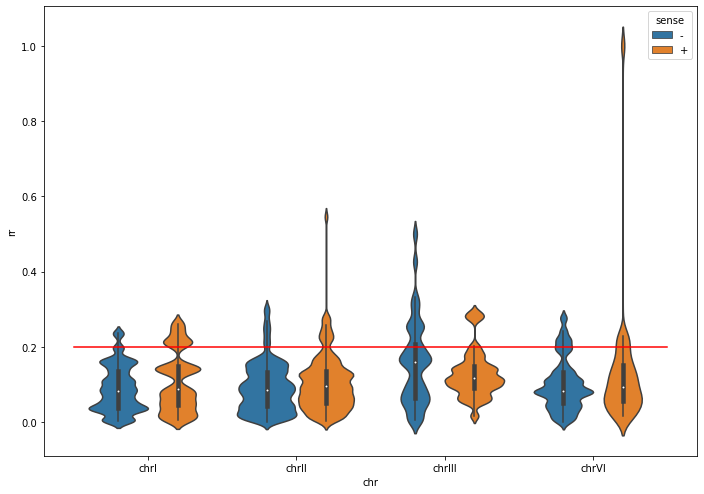

In [28]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='sense', bw=.15, data=detect_repair_ig_gtf[detect_repair_ig_gtf.chr.isin(['chrI', 'chrII', 'chrIII', 'chrVI'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

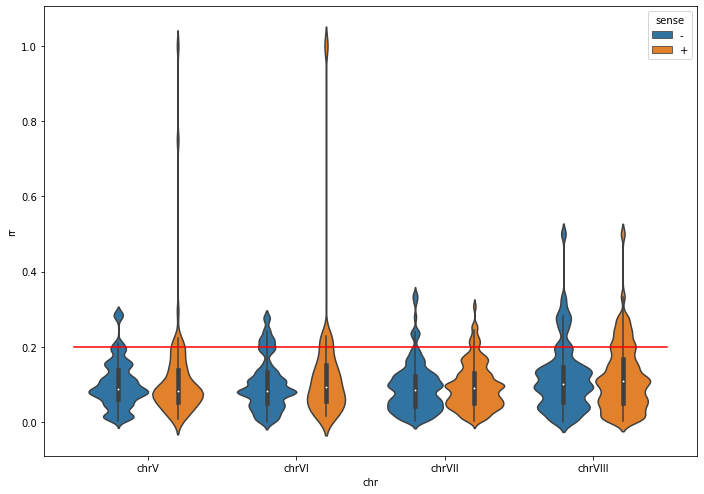

In [29]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='sense', bw=.15, data=detect_repair_ig_gtf[detect_repair_ig_gtf.chr.isin(['chrV', 'chrVI', 'chrVII', 'chrVIII'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

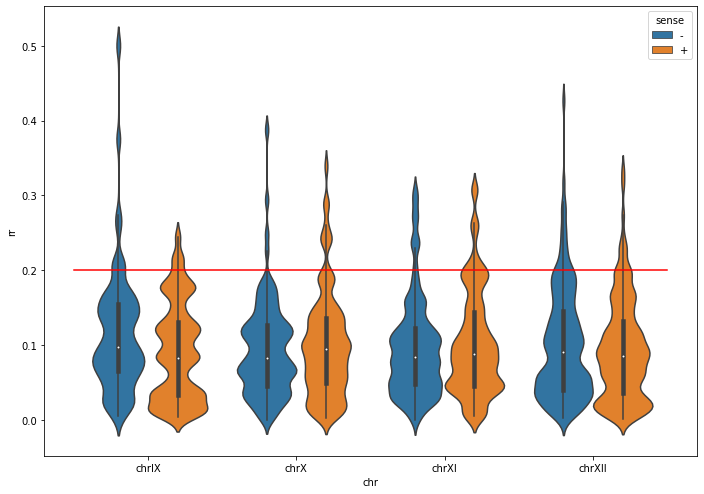

In [30]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='sense', bw=.15, data=detect_repair_ig_gtf[detect_repair_ig_gtf.chr.isin(['chrIX', 'chrX', 'chrXI', 'chrXII'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()

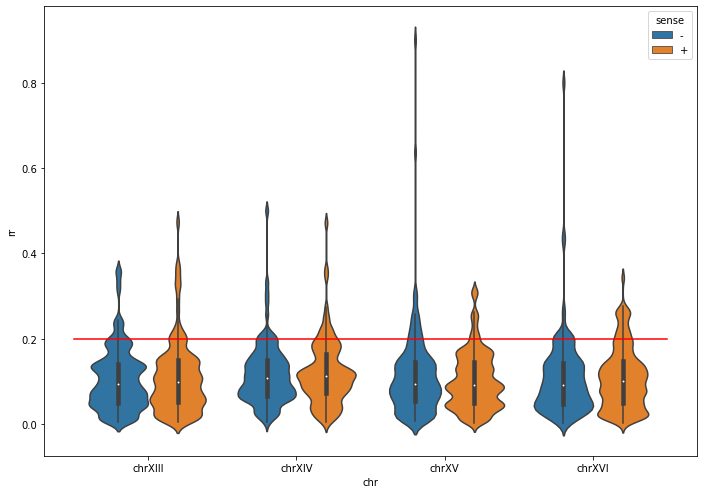

In [31]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sb.violinplot(x='chr', y='rr', hue='sense', bw=.15, data=detect_repair_ig[detect_repair_ig.chr.isin(['chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chrXVII'])], ax=ax)
ax.plot(np.arange(-.5, 4.5), np.ones(5) * .2, color='red')
plt.show()